In [1]:
!python -V

Python 3.11.7


In [3]:
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

 # Extract

In [11]:
## read the parquet file and check data types
df = pd.read_parquet('/home/yassinfahmy/mlops-training/data/green_tripdata_2024-01.parquet')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56551 entries, 0 to 56550
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   VendorID               56551 non-null  int32         
 1   lpep_pickup_datetime   56551 non-null  datetime64[us]
 2   lpep_dropoff_datetime  56551 non-null  datetime64[us]
 3   store_and_fwd_flag     53136 non-null  object        
 4   RatecodeID             53136 non-null  float64       
 5   PULocationID           56551 non-null  int32         
 6   DOLocationID           56551 non-null  int32         
 7   passenger_count        53136 non-null  float64       
 8   trip_distance          56551 non-null  float64       
 9   fare_amount            56551 non-null  float64       
 10  extra                  56551 non-null  float64       
 11  mta_tax                56551 non-null  float64       
 12  tip_amount             56551 non-null  float64       
 13  t

# Transform

In [17]:
## calculate the duration of the ride
df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
## convert the value to minutes (first to seconds then divide by 60
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

##select only values ranging from 1 to 60 mins because the distribution is too large
df = df[(df.duration >= 1) & (df.duration <= 60)]



# Build and test model

In [31]:
#identify and enforce datatypes
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

##one hot encodes categorical variables if they are string
df[categorical] = df[categorical].astype(str)
train_dicts = df[categorical + numerical].to_dict(orient='records')
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

mean_squared_error(y_train, y_pred, squared=False)

7.1270423781588965

/tmp/ipykernel_14548/1672306066.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
/home/yassinfahmy/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/tmp/ipykernel_14548/1672306066.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level

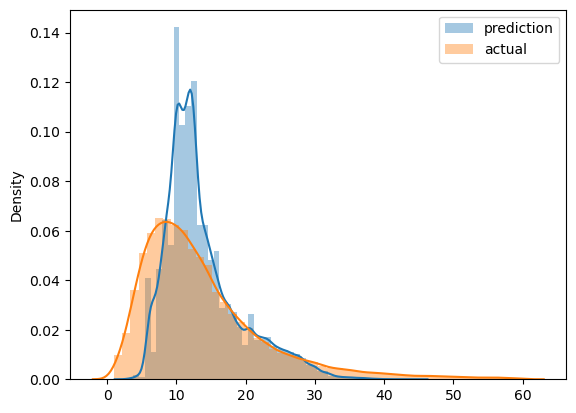

In [32]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

# put E and T in func

In [33]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [42]:
df_train = read_dataframe('/home/yassinfahmy/mlops-training/data/green_tripdata_2024-01.parquet')
df_val = read_dataframe('/home/yassinfahmy/mlops-training/data/green_tripdata_2023-01.parquet')

In [43]:
len(df_train), len(df_val)

(54373, 65946)

In [44]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [45]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [46]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

6.1661951125966965

## save the model witht the vectorization instance


In [51]:
with open('models/linear_regression.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

# try a Lasso regularized model

In [55]:
lr = Lasso(0.1)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

8.942209504097129